# ベイズ勉強会 Part 8 ポアソン混合モデル

> ポアソン混合モデルの近似推論

- toc: true 
- badges: true
- comments: true
- categories: [bayes]
- image: images/mpm.png

ベイズ勉強会資料は『ベイズ推論による機械学習入門』{% fn 1 %}を元に、途中式計算をできるだけ省略せずに解説を行ったものです。

今回は4.1~4.3の内容を扱います。

※2020/06/03追記: 趣旨とは外れますが、Distributions.jlのより高度な機能を用いた効率的な実装をご紹介いただきました。ありがとうございました。

> Twitter: https://twitter.com/genkuroki/status/1268036932417675270

In [1]:
# 使うパッケージ
using Distributions
using StatsBase
using LinearAlgebra
using SpecialFunctions
ENV["GKS_ENCODING"]="utf8" # Plot内でunicode使うためのおまじない
using Plots
using StatsPlots
using Flux: onehot

## 登場する確率分布(再掲)

### カテゴリ分布

カテゴリ分布は次のような確率質量関数を分布関数にもつ確率分布である。

$$
Cat({\bf s}|{\bf \pi}) = \Pi_{k=1}^{K} \pi_k^{s_k}
$$

${\bf s}$はK次元ベクトルで、該当カテゴリのみを1,それ以外を0で表したものである(1 of K 表現)。例えば、サイコロの目を確率変数とすれば$s = 5$と書く代わりに、${\bf s} = (0,0,0,0,1,0)^\mathrm{T}$と書く。パラメータ${\bf \pi} = (\pi_1,\dots,\pi_K)^\mathrm{T}$は各カテゴリに配される確率を表したものであり、$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k = 1$を満たす。

対数をとると

$$
\ln Cat({\bf s}|{\bf \pi}) = \Sigma_{k=1}^{K} s_k \ln \pi_k
$$

となる。

### ディリクレ分布

尤度関数にカテゴリ分布をとった場合、パラメータ${\bf \pi}$の事前分布は、$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k = 1$を満たすK次元ベクトルを出力する必要がある。このような分布として、ディリクレ分布がある。ディリクレ分布の分布関数は次のようになる。

$$
Dir({\bf \pi}|{\bf \alpha}) = C_D ({\bf \alpha}) \Pi_{k=1}^{K} \pi_k^{\alpha_k - 1}
$$

ディリクレ分布のパラメータ${\bf \alpha} = (\alpha_1, \dots, \alpha_K)^\mathrm{T}$の要素$\alpha_k$は正の実数である。正規化係数は

$$
C_D ({\bf \alpha}) = \frac{\Gamma (\Sigma_{k=1}^{K} \alpha_k)}{\Pi_{k=1}^{K} \Gamma (\alpha_k)}
$$

である。

対数をとると

$$
\ln Dir({\bf \pi}|{\bf \alpha}) = \Sigma_{k=1}^{K} (\alpha_k - 1) \ln \pi_k + \ln C_D ({\bf \alpha})
$$

となる。

### ポアソン分布

ポアソン分布は次のような確率密度関数を分布関数にもつ確率分布である。

$$
\mathrm{Poi} (x|\lambda) = \frac{\lambda^x}{x!} \mathrm{e}^{-\lambda}
$$

xは非負の整数、パラメータ$\lambda$は正の実数である。

対数をとると

$$
\ln \mathrm{Poi} (x|\lambda) = x \ln \lambda - \ln x! - \lambda
$$

である。

### ガンマ分布

ポアソン分布のパラメータ$\lambda$は正の実数であるので、事前分布$p(\lambda)$はガンマ分布で表すと都合が良い。ガンマ分布は次のような確率密度関数を分布関数にもつ確率分布である。

$$
\mathrm{Gam}(\lambda|a,b) = C_G(a,b)\lambda^{a-1} \mathrm{e}^{-b\lambda}
$$

正規化係数$C_G(a,b)$は次のような関数である。

$$
C_G(a,b) = \frac{b^a}{\Gamma(a)}
$$

ガンマ分布の対数をとると

$$
\ln \mathrm{Gam}(\lambda|a,b) = (a-1)\ln \lambda - b\lambda + \ln C_G(a,b)
$$

である。

## モデル構築

これまでは次のような1峰性の分布の密度推定をするモデルを扱ってきた。

$$
\begin{eqnarray}
p({\bf X},\lambda) &=& p({\bf X}|\lambda)p(\lambda) \\
ただし　p({\bf X}) &=& \Pi_{n=1}^{N} \mathrm{Poi}(x_n|\lambda) \\
p(\lambda) &=& \mathrm{Gam}(\lambda|a,b)
\end{eqnarray}
$$

In [2]:
# ポアソン分布による密度推定用のモデル
mutable struct PoisModel
    a::Float64
    b::Float64
end

In [3]:
# 事前予測分布を計算する関数
function predict(model::PoisModel)
    r = model.a
    p = 1 / (model.b + 1)
    predict_dist = NegativeBinomial(r, p)
    return predict_dist
end

predict (generic function with 1 method)

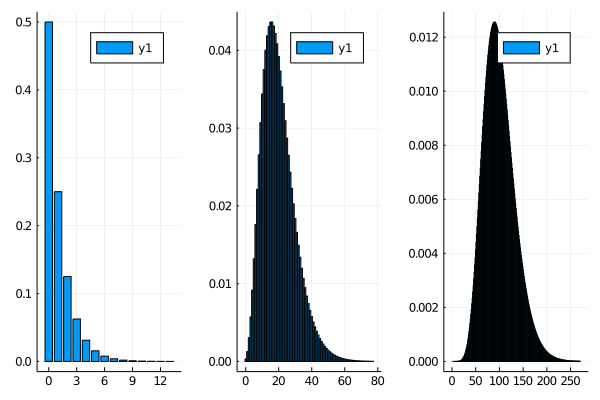

In [4]:
# ハイパーパラメータの値を変えても、1峰性であることは変わらない
p1 = bar(predict(PoisModel(1,1)))
p2 = bar(predict(PoisModel(5,4)))
p3 = bar(predict(PoisModel(10,10)))
plot(p1,p2,p3,layout=(1,3))

このモデルには次のような多峰性の分布を持つデータを表現することができないという欠点がある。

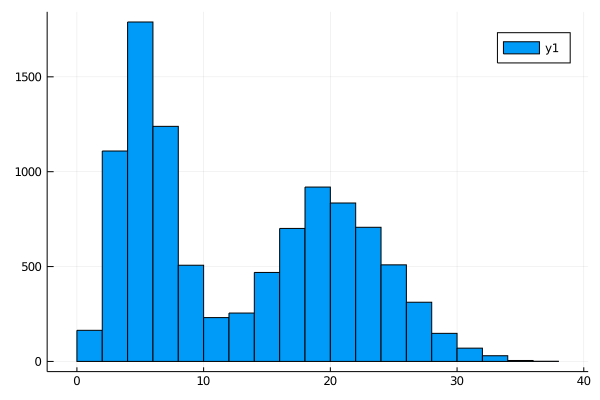

In [5]:
# λ=5とλ=20のポアソン分布から半々の確率で生成したデータ点
Ys = []
for i in 1:10000
    K = rand(Categorical([0.5,0.5]))
    λ = ifelse(K==1,5,20)
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
histogram(Ys)

そこで、「データを複数のクラスタ(集団)に分けることができ、クラスタごとに異なるポアソン分布から生成されている」という仮定をおいてみることにする。これはカテゴリ分布とポアソン分布を組み合わせることで実現できる。

モデルにおけるN個のデータ点${\bf X} = \{ x_1,\dots,x_N \}$の生成過程を記述すると次(参考資料より引用{% fn 1 %})のようになる。クラスタ数Kは既知とする。

1. それぞれのクラスタの混合比率${\bf \pi} = (\pi_1,\dots,\pi_K)^\mathrm{T}$が事前分布$p({\bf \pi})$から生成される（ただし$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k=1$）。
2. それぞれのクラスタ$k=1,\dots,K$に対する観測モデルのパラメータ$\theta_k$（平均や分散）が事前分布$p(\theta_k)$から生成される。
3. $n=1,\dots,N$に関して、$x_n$に対するクラスタの割当$s_n$が比率${\bf \pi}$によって選ばれる。
4. $n=1,\dots,N$に関して、$s_n$によって選択されたk番目の確率分布$p(x_n|\theta_k)$からデータ点$x_n$が生成される。

この生成過程を同時分布の形で書くと次のようになる。$s_n$を1 of K表現で表し、${\bf S} = \{ s_1,\dots,s_N \}$とする。

$$
\begin{eqnarray}
    p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) &=& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})p({\bf \lambda})p({\bf \pi}) \\
    &=& \{ \Pi_{n=1}^{N} p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi}) \} \{ \Pi_{k=1}^{K} p(\lambda_k) \} p({\bf \pi}) \\
    ただし　p({\bf \pi}) &=& \mathrm{Dir}({\bf \pi}|{\bf \alpha}) \\
    p(\lambda_k) &=& \mathrm{Gam}(\lambda_k|a,b) \\
    p(x_n|s_n,{\bf \lambda}) &=& \Pi_{k=1}^{K} \mathrm{Poi}(x_n|\lambda_k)^{s_{n,k} }
\end{eqnarray}
$$

このようにモデルの生成過程に対する仮定を元に記述したモデルを生成モデルと呼ぶ。また、直接観測されることのないカテゴリ変数$s_n$を隠れ変数または潜在変数と呼ぶ。

以下ではこのモデルの出力がどのようになるかをハイパーパラメータを変えてシミュレーションしている。

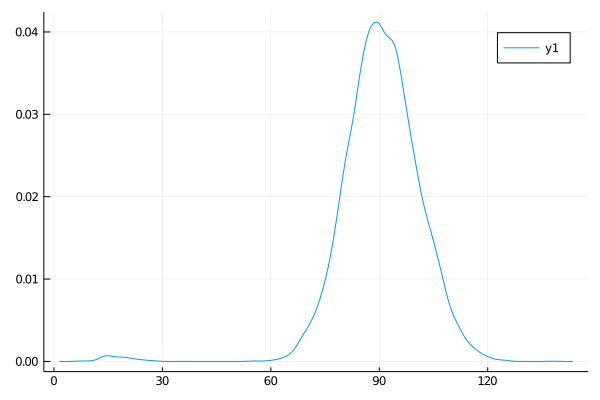

In [6]:
# カテゴリ数を3とする
λs = rand.([Gamma(1,1), Gamma(5,5), Gamma(10,10)])
pi = rand(Dirichlet([0.01,0.19,0.80]))
Ys = []
for i in 1:10000
    s = rand(Categorical(pi))
    λ = λs[s]
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

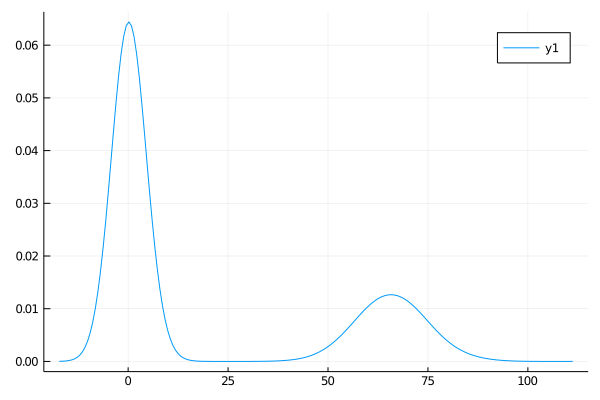

In [7]:
# カテゴリ数を3とする
λs = rand.([Gamma(1,1), Gamma(2,3), Gamma(10,10)])
pi = rand(Dirichlet([0.25,0.20,0.55]))
Ys = []
for i in 1:10000
    s = rand(Categorical(pi))
    λ = λs[s]
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

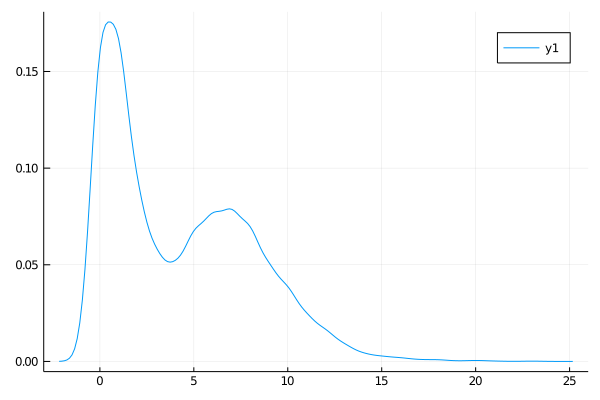

In [8]:
# カテゴリ数を3とする
λs = rand.([Gamma(1,1), Gamma(5,1), Gamma(10,1)])
pi = rand(Dirichlet([0.33,0.34,0.33]))
Ys = []
for i in 1:10000
    s = rand(Categorical(pi))
    λ = λs[s]
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
density(Ys)

ハイパーパラメータの値を適当に変えることで、多彩な表現ができることがわかる。

## 事後分布の推論に近似推論が必要な理由

同時分布の形で書いているので、事後分布は観測された変数${\bf X}$の分布で割れば求まる。

$$
p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X}) = \frac{p({\bf X},{\bf S},{\bf \lambda},{\bf \pi})}{p({\bf X})}
$$

しかしこれを計算することは現実的には困難であることが知られている。分母の$p({\bf X})$を計算しようとすると、

$$
\begin{eqnarray}
    p({\bf X}) &=& \Sigma_{S} \int \int p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) d {\bf \lambda} d {\bf \pi} \\
    &=& \Sigma_{S} p({\bf X},{\bf S})
\end{eqnarray}
$$

を解くことになるが、共役事前分布を使うことによりパラメータ${\bf \lambda},{\bf \pi}$については解析的に積分除去可能になるが、$p({\bf X},{\bf S})$を${\bf S}$のとりうる全ての組み合わせについて計算する必要がある。N個の要素がK個のクラスタに分類されるので$K^N$回計算する必要があり、現実的に不可能な計算量になってしまう。そこでMCMC,変分推論といった近似推論手法を用いる必要がある。

## ギブスサンプリング

上でも行っているように、確率分布の特徴は実際にサンプルすることでわかってくる。MCMC法の1種であるギブスサンプリングでは、モデルが複雑なため同時にサンプルすることが難しい各確率変数を、順番にサンプルしていく。

例えば、確率分布$p(z_1,z_2,z_3)$があったときに、一度に$z_1^{(i)},z_2^{(i)},z_3^{(i)} \sim p$とするのは困難であるとする。そのとき、i個目の各変数を次のように順番にサンプルしていくことを考える。

$$
\begin{eqnarray}
    z_1^{(i)} &\sim& p(z_1|z_2^{(i-1)},z_3^{(i-1)}) \\
    z_2^{(i)} &\sim& p(z_2|z_1^{(i)}, z_3^{(i-1)}) \\
    z_3^{(i)} &\sim& p(z_3|z_1^{(i)}, z_2^{(i)})
\end{eqnarray}
$$

1個前の値を使うことで分布を条件づけし簡単な確率分布を得るというアイデアである。$z_1^{1}$をサンプルするために$z_2^{0}, z_3^{0}$は何らかのランダムな初期値を与えてやるのが一般的である。

## ポアソン混合モデルのギブスサンプリング

データ${\bf X}$が観測された後の条件つき分布は

$$
p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X})
$$

となる。この分布は複雑であるため直接${\bf S},{\bf \lambda},{\bf \pi}$をサンプルすることは難しい。混合分布の場合は潜在変数とパラメータを分けてサンプルすると十分に簡単な確率分布が得られることが知られているので、以下の戦略で各確率変数をサンプルしていく。

$$
\begin{eqnarray}
    {\bf S} &\sim& p({\bf S}|{\bf X},{\bf \lambda},{\bf \pi}) \\
    {\bf \lambda}, {\bf \pi} &\sim& p({\bf \lambda},{\bf \pi}|{\bf X},{\bf S})
\end{eqnarray}
$$

### 潜在変数${\bf S}$をサンプルする分布

まず潜在変数${\bf S}$をサンプルするための条件付き分布を求める。ここでは、パラメータ${\bf \lambda}, {\bf \pi}$も与えられていると考える。

$$
\begin{eqnarray}
    p({\bf S}|{\bf X},{\bf \lambda},{\bf \pi}) &\propto& p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X})　(分母は{\bf S}に関わらない) \\
    &\propto& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})　(p({\bf \lambda}),p({\bf \pi})は{\bf S}に関わらない) \\
    &=& \Pi_{n=1}^{N} p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi})
\end{eqnarray}
$$

結果、$p({\bf S}|{\bf X},{\bf \lambda},{\bf \pi})$は各$s_1,\dots,s_N$の分布の積に比例する、つまり条件付き独立な分布に分解できることがわかる。

具体的に、$s_n$をサンプルするための確率分布を計算してみる。指数部分の計算になるので対数をとる。

$$
\begin{eqnarray}
    \ln p(x_n|s_n,{\bf \lambda}) &=& \Sigma_{k=1}^{K} s_{n,k} \ln \mathrm{Poi}(x_n|\lambda_k) \\
    &=& \Sigma_{k=1}^{K} s_{n,k} (x_n \ln \lambda_k - \lambda_k) + const.
\end{eqnarray}
$$

また、

$$
\begin{eqnarray}
    \ln p(s_n|{\bf \pi}) &=& \ln \mathrm{Cat}(s_n|{\bf \pi}) \\
    &=& \Sigma_{k=1}^{K} s_{n,k} \ln \pi_k
\end{eqnarray}
$$

ゆえ

$$
\ln p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi}) = \Sigma_{k=1}^{K} s_{n,k} (x_n \ln \lambda_k - \lambda_k + \ln \pi_k) + const.
$$

ここで、$\Sigma_{k=1}^{K} s_{n,k} = 1$という制約があるのでこれはカテゴリ分布に対数をとった形として見ることができる。よって簡略化のため新しいパラメータ変数$\eta_{n}$を用意すると次のようにまとめられる。

$$
\begin{eqnarray}
    s_n &\sim& \mathrm{Cat}(s_n|\eta_n) \\
    ただし　\eta_{n,k} &\propto& \mathrm{exp} \{ x_n \ln \lambda_k - \lambda_k + \ln \pi_k \}　( s.t. \Sigma_{k=1}^{K} \eta_{n,k} = 1 )
\end{eqnarray}
$$

このように各nで$\eta_{n,k}$を計算することにより$s_n$をカテゴリ分布からサンプルできる。

### パラメータ${\bf \lambda},{\bf \pi}$をサンプルする分布

今度は潜在変数${\bf S}$を観測された値のように扱う。

$$
\begin{eqnarray}
    p({\bf \lambda},{\bf \pi}|{\bf X},{\bf S}) &\propto& p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X}) \\
    &=& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})p({\lambda})p({\bf \pi})
\end{eqnarray}
$$

このとき、${\bf \lambda},{\bf \pi}$に関する項は別々に分解できている。${\bf X}, {\bf S}$が与えられた条件下では独立となっているということである。

まず${\bf \lambda}$の分布を計算する。対数をとって

$$
\begin{eqnarray}
    \ln p({\bf X}|{\bf S},{\bf \lambda}) &=& \Sigma_{n=1}^{N} \Sigma_{k=1}^{K} s_{n,k} \ln \mathrm{Poi}(x_n|\lambda_k) + \Sigma_{k=1}^{K} \ln \mathrm{Gam} (\lambda_k|a,b) \\
    &=& \Sigma_{k=1}^{K} \left\{ (\Sigma_{n=1}^{N} s_{n,k} x_n + a - 1) \ln \lambda_k - (\Sigma_{n=1}^{N} s_{n,k} + b) \lambda_k \right\} + const.
\end{eqnarray}
$$

これは独立したK個のガンマ分布の積に対数をとった形であり、$\lambda_k$は次のガンマ分布からサンプルされる。

$$
\begin{eqnarray}
    \lambda_k &\sim& \mathrm{Gam}(\lambda_k|\hat{a}_k,\hat{b}_k) \\
    ただし　\hat{a}_k &=& \Sigma_{n=1}^{N} s_{n,k} x_n + a \\
    \hat{b}_k &=& \Sigma_{n=1}^{N} s_{n,k} + b
\end{eqnarray}
$$

次に、${\bf \pi}$の分布を計算する。対数をとって

$$
\begin{eqnarray}
    \ln p({\bf S}|{\bf \pi})p({\bf \pi}) &=& \Sigma_{n=1}^{N} \ln \mathrm{Cat}(s_n|{\bf \pi}) \\
    &=& \Sigma_{k=1}^{K} (\Sigma_{n=1}^{N} s_{n,k} + \alpha_k - 1) \ln \pi_k + const.
\end{eqnarray}
$$

となり、${\bf \pi}$は次のディリクレ分布からサンプルできる。

$$
\begin{eqnarray}
    {\bf \pi} &\sim& \mathrm{Dir}({\bf \pi}|\hat{\bf \alpha}) \\
    ただし　\hat{\alpha}_k &=& \Sigma_{n=1}^{N} s_{n,k} + \alpha_k
\end{eqnarray}
$$

### まとめ

結局、ポアソン混合モデルのためのギブスサンプリングのアルゴリズムは次のようになる。

> Important: ポアソン混合モデルのためのギブスサンプリングアルゴリズム

> パラメータのサンプル${\bf \lambda},{\bf \pi}$に初期値を設定
>
> for $i = 1,\dots,\mathrm{MAXITER}$ do
>
> 　for n = $1,\dots,N$ do
> 　　$s_n$をサンプル
>
> 　end for
>
> 　for k = $1,\dots,K$ do
>
> 　　$\lambda_k$をサンプル
>
> 　end for
> 　${\bf \pi}$をサンプル
>
> end for

なおサンプルするごとに学習が進んでいくが、初期値によって異なる値にたどり着くことがあるので、複数の初期値からサンプルして結果の収束を見る必要がある。

### Juliaによる実装

以上をJuliaにより実装する。

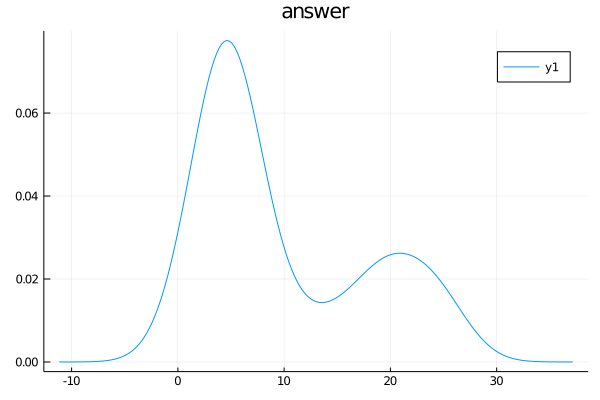

In [9]:
# データ点作成
# λ=5とλ=20のポアソン分布から7:3の確率で生成したデータ点
X = []
for i in 1:100
    K = rand(Categorical([0.7,0.3]))
    λ = ifelse(K==1,5,20)
    x = rand(Poisson(λ))
    push!(X,x)
end
p_ans = density(X, title="answer")
plot(p_ans)

In [10]:
# ギブスサンプリングを実行

# chain数は4とする
N = length(X)
K = 2
n_chain = 4
S_mcmc = []
lambda_mcmc = []
pi_mcmc = []

for i in 1:n_chain
    a = [1.,1.]
    b = [1.,1.]
    alpha = [1/2,1/2]
    # 初期値をチェインごとにランダムに作る
    lambda = abs.(rand(MultivariateNormal([1.,1.],I(2))))
    pi = rand(Dirichlet([1/2,1/2]))

    S_chain = []
    lambda_chain = []
    pi_chain = []

    @time for i in 1:2000
        S = []
        for n in 1:N
            eta_n = exp.(X[n] .* log.(lambda) .- lambda .+ log.(pi))
            eta_n = eta_n ./ sum(eta_n) # 合計が1になるように合計値で割る
            s_n = rand(Categorical(eta_n))
            s_n = onehot(s_n, [1,2])
            push!(S, s_n)
        end
        a = sum(S.*X) .+ a
        b = sum(S) .+ b
        lambda = rand.(Gamma.(a,1 ./ b))
        alpha = sum(S) .+ alpha
        pi = rand(Dirichlet(alpha))
        push!(S_chain, S)
        push!(lambda_chain, lambda)
        push!(pi_chain, pi)
    end
    push!(S_mcmc, S_chain)
    push!(lambda_mcmc, lambda_chain)
    push!(pi_mcmc, pi_chain)
end

  3.091110 seconds (7.41 M allocations: 333.948 MiB, 5.10% gc time)
  1.767400 seconds (5.26 M allocations: 227.237 MiB, 5.01% gc time)
  1.825786 seconds (5.26 M allocations: 227.237 MiB, 11.16% gc time)
  1.546258 seconds (5.26 M allocations: 227.237 MiB, 11.65% gc time)


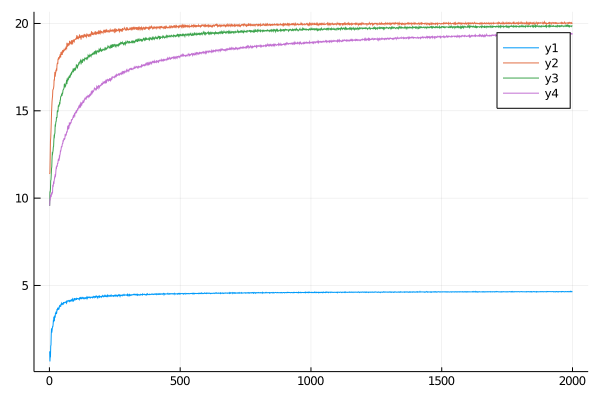

In [11]:
# クラスタ1に対するlambda
plot(1:2000,[l[1] for l in lambda_mcmc[1]])
plot!(1:2000,[l[1] for l in lambda_mcmc[2]])
plot!(1:2000,[l[1] for l in lambda_mcmc[3]])
plot!(1:2000,[l[1] for l in lambda_mcmc[4]])

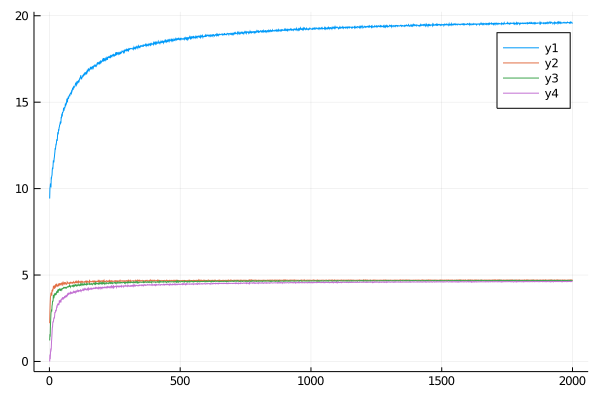

In [12]:
# クラスタ2に対するlambda
plot(1:2000,[l[2] for l in lambda_mcmc[1]])
plot!(1:2000,[l[2] for l in lambda_mcmc[2]])
plot!(1:2000,[l[2] for l in lambda_mcmc[3]])
plot!(1:2000,[l[2] for l in lambda_mcmc[4]])

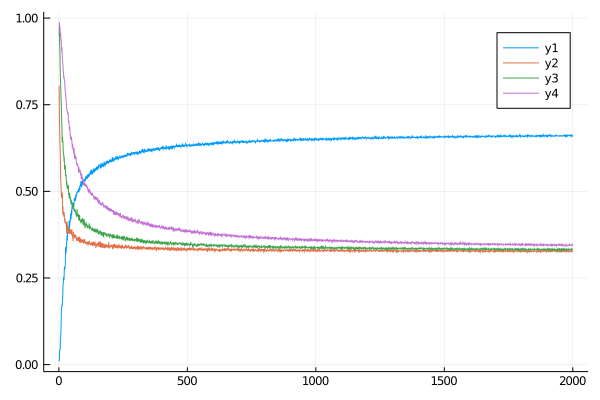

In [13]:
# クラスタ1に割り振られる確率
plot(1:2000,[p[1] for p in pi_mcmc[1]])
plot!(1:2000,[p[1] for p in pi_mcmc[2]])
plot!(1:2000,[p[1] for p in pi_mcmc[3]])
plot!(1:2000,[p[1] for p in pi_mcmc[4]])

クラスタの順番が逆になっているだけで、収束はしている。

チェイン1のサンプルを使って予測分布を書いてみる。収束する前のサンプルは使えないので1001以降のものを使う。

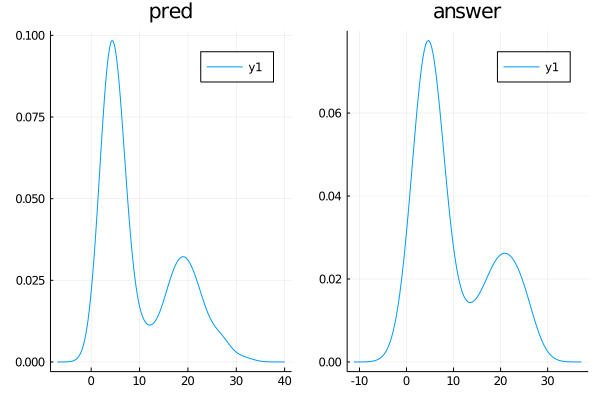

In [14]:
xs = []
for i in 1001:2000
    pi = pi_mcmc[1][i]
    lambda = ifelse(rand(Categorical(pi))==1,lambda_mcmc[1][i][1],lambda_mcmc[1][i][2])
    x = rand(Poisson(lambda))
    push!(xs, x)
end
p_pred = density(xs, title="pred")
plot(p_pred, p_ans, layout=(1,2))

## 変分推論

MCMCとならぶベイズ推論の近似手法が変分推論である。これは「モデルの確率分布が複雑ならより簡単な近似分布で表そう」という考え方によるものである。もちろん元の分布に近い方が良く、元の分布と近似分布の「似ている度」をKLダイバージェンスで評価することで、良い近似分布を導出する作業は次のように定式化できる。

$$
q_\mathrm{opt.} (z_1,z_2,z_3) = \mathrm{argmin}_{q} \mathrm{KL} [q(z1,z2,z3)||p(z1,z2,z3)]
$$

> Important: 確率分布$p(x)$に対する関数$f(x)$の期待値 $$\langle f(x) \rangle_{p(x)} = \int f(x)p(x) dx$$

> Important: KLダイバージェンス $$\begin{eqnarray} \mathrm{KL}[q(x)||p(x)] &=& - \int q(x) \ln \frac{p(x)}{q(x)} dx \\ &=& \langle \ln q(x) \rangle_{q(x)} - \langle \ln p(x) \rangle_{q(x)} \end{eqnarray}$$ 

> Tip: STEINS;GATEで世界線同士の相対的な近さをダイバージェンス(世界線変動率)って呼んでましたね。変分推論も世界線の旅と考えたらオカリンの気分を味わえて面白いかも。

この最適化問題を制約なしに解いても元の分布$p(z_1,z_2,z_3)$が最適ということになり何も解決しないのでいくつかの制約を置くことになる。典型的なものが平均場近似と呼ばれる、各変数を独立とみなす仮定をおいた変分推論である。

$$
p(z_1,z_2,z_3) \approx q(z_1)q(z_2)q(z_3)
$$

平均場近似の場合の最適化問題を解いていく。平均場近似でもMCMCと似たように、変数の分布を1つずつ最適化していく。そこで、$q(z_2),q(z_3)$を固定して$q(z_1)$を最適化する。以下の式では期待値計算を$\langle \dot \rangle_{q(z_1),q(z_2),q(z_3)} = \langle \dot \rangle_{1,2,3}$と簡略化して書く。

$$
\begin{eqnarray}
    \mathrm{KL}[q(z_1)q(z_2)q(z_3)||p(z_1,z_2,z_3)] &=& - \langle \ln \frac{p(z_1,z_2,z_3)}{q(z_1)q(z_2)q(z_3)}\rangle_{1,2,3} \\
    &=& - \langle \langle \ln \frac{p(z_1,z_2,z_3}{q(z_1)q(z_2)q(z_3)} \rangle_{2,3} \rangle_{1} \\
    &=& - \langle \langle \ln p(z_1,z_2,z_3) \rangle_{2,3} - \langle q(z_1) \rangle_{2,3} - \langle q(z_2) \rangle_{2,3} - \langle q(z_3) \rangle_{2,3} \rangle_{1}　(期待値の線形性) \\
    &=& - \langle \langle \ln p(z_1,z_2,z_3) \rangle_{2,3} - q(z_1) \rangle_{1} + const. \\
    &=& - \langle \ln \frac{\exp \{ \langle \ln p(z_1,z_2,z_3) \rangle_{2,3} \} }{q(z_1)} \rangle_{1} + const.　(\expでくくり\lnでまとめる) \\
    &=& \mathrm{KL} [q(z_1)||\exp \{ \{ \langle \ln p(z_1,z_2,z_3) \rangle_{2,3} \} ] + const.
\end{eqnarray}
$$

これで$q(z_1)$だけをくくり出せたので、最適な$q(z_1)$は

$$
\ln q(z_1) = \langle \ln p(z_1,z_2,z_3) \rangle_{2,3} + const.
$$

という等式で得られる。$q(z_2),q(z_3)$でも全く同じ議論ができ、平均場近似による変分推論のアルゴリズムは次のようになる。

> Important: 平均場近似による変分推論のアルゴリズム(3変数)

> $q(z_2),q(z_3)$を初期化
>
> for $i=1,\dots,\mathrm{MAXITER}$ do
>
> 　$\ln q(z_1) = \langle \ln p(z_1,z_2,z_3) \rangle_{2,3} + const.$
>
> 　$\ln q(z_2) = \langle \ln p(z_1,z_2,z_3) \rangle_{1,3} + const.$
>
> 　$\ln q(z_3) = \langle \ln p(z_1,z_2,z_3) \rangle_{1,2} + const.$
>
> end for

現実的な想定として、観測データ$\mathcal{D}$が与えられた確率モデル$p(\mathcal{D},z_1,\dots,z_M)$の事後分布に対する近似公式を作ると次のようになる。なお未観測変数$z_1,\dots,z_M$から$z_i$を除いた集合を${\bf Z}_{\verb|\| i}$と表す

> Important: 事後分布に対する近似公式 $$\begin{eqnarray} \ln q(z_i) &=& \langle \ln p(z_1,\dots,z_M|\mathcal{D}) \rangle_{q({\bf Z}_{\verb|\| i} ) }+const. \\ &=& \langle \ln p(\mathcal{D},z_1,\dots,z_M) \rangle_{q({\bf Z}_{\verb|\| i} ) } + const. \end{eqnarray}$$

## ポアソン混合モデルの変分推論

ギブスサンプリングと同じように、変分推論でも潜在変数とパラメータを分けることでうまくいくことが知られている。次のように事後分布を近似する。

$$
p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X}) \approx q({\bf S})q({\bf \lambda},{\bf \pi})
$$

このように潜在変数とパラメータを分けて近似する変分推論手法を変分ベイズEMアルゴリズムと呼ぶ場合がある。最尤推定におけるEMアルゴリズムと似ているためである。

### 潜在変数${\bf S}$の近似事後分布

事後分布に対する近似公式に当てはめると$q({\bf S})$は

$$
\begin{eqnarray}
    \ln q({\bf S}) &=& \langle \ln p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) \rangle_{q({\bf \lambda},{\bf \pi})} + const. \\
    &=& \langle p({\bf X}|{\bf S},{\bf \lambda}) \rangle_{q({\bf \lambda})} + \langle \ln p({\bf S}|{\bf \pi}) \rangle_{q({\bf \pi})} + const. \\
    &=& \Sigma_{n=1}^{N} \left\{ \langle \ln p(x_n|s_n,{\bf \lambda}) \rangle_{q({\bf \lambda})} + \langle \ln p(s_n|{\bf \pi}) \rangle_{q({\bf \pi})}  \right\} + const.
\end{eqnarray}
$$

と、N個の独立な分布$q(s_n)$に分解されることがわかる。それぞれの期待値の項は

$$
\begin{eqnarray}
    \langle \ln p(x_n|s_n,{\bf \lambda}) \rangle_{q({\bf \lambda})} &=& \Sigma_{k=1}^{K} \langle s_{n,k} \ln \mathrm{Poi}(x_n|\lambda_k) \rangle_{q(\lambda_k)} \\
    &=& \Sigma_{k=1}^{K} s_{n,k} (x_n \langle \ln \lambda_k \rangle - \langle \lambda_k \rangle) + const.
\end{eqnarray}
$$

および

$$
\begin{eqnarray}
    \langle \ln p(s_n|{\bf \pi}) \rangle_{q({\bf \pi})} &=& \langle \ln \mathrm{Cat}(s_n|{\bf \pi}) \rangle_{q({\bf \pi})} \\
    &=& \Sigma_{k=1}^{K} s_{n,k} \langle \ln \pi_k \rangle
\end{eqnarray}
$$

であり、ギブスサンプリングの時と同様の議論により近似分布$q(s_n)$は次のようなカテゴリ分布となることがわかる。

$$
\begin{eqnarray}
    q(s_n) &=& \mathrm{Cat} (s_n|\eta_n) \\
    ただし　\eta_{n,k} &\propto& \exp \{ x_n \langle \ln \lambda_k \rangle - \langle \lambda_k \rangle + \langle \ln \pi_k \rangle \}　( s.t. \Sigma_{k=1}^{K} \eta_{n,k} = 1 )
\end{eqnarray}
$$

${\bf \lambda},{\bf \pi}$に関する期待値計算は、$q({\bf \lambda}),q({\bf \pi})$の形式が明らかにならないとできないので後回しとする。

### パラメータ${\bf \lambda},{\bf \pi}$の近似事後分布

ここでも公式を用いると

$$
\begin{eqnarray}
    \ln q({\bf \lambda},{\bf \pi}) &=& \langle \ln p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) \rangle_{q({\bf S})} + const. \\
    &=& \langle \ln p({\bf X}|{\bf S},{\bf \lambda}) \rangle_{q({\bf S})} + \ln p({\bf \lambda}) + \langle \ln p({\bf S}|{\bf \pi}) \rangle_{q({\bf S})} + \ln p({\bf \pi}) + const.
\end{eqnarray}
$$

と、$q({\bf \lambda},{\bf \pi}) = q({\bf \lambda})q({\bf \pi})$と分解できることがわかる。

はじめに${\bf \lambda}$に関係する項のみを取り出して計算すると

$$
\begin{eqnarray}
    \ln q({\bf \lambda}) &=& \Sigma_{n=1}^{N} \langle \Sigma_{k=1}^{K} s_{n,k} \ln \mathrm{Poi}(x_n|\lambda_k) \rangle_{q(s_n)} + \Sigma_{k=1}^{K} \ln \mathrm{Gam} (\lambda_k|a,b) + const. \\
    &=& \Sigma_{k=1}^{K} \left\{ (\Sigma_{n=1}^{N} \langle s_{n,k} \rangle x_n + a - 1) \ln \lambda_k - (\Sigma_{n=1}^{N} \langle s_{n,k} \rangle + b) \lambda_k \right\} + const.
\end{eqnarray}
$$

となり、$q({\bf \lambda})$はK個の独立なガンマ分布に分けられる。

$$
\begin{eqnarray}
    q(\lambda_k) &=& \mathrm{Gam}(\lambda_k|\hat{\alpha}_k,\hat{b}_k) \\
    ただし　\hat{a}_k &=& \Sigma_{n=1}^{N} \langle s_{n,k} \rangle x_n + a \\
    \hat{b}_k &=& \Sigma_{n=1}^{N} \langle s_{n,k} \rangle + b
\end{eqnarray}
$$

次に、${\bf \pi}$に関係する項のみで計算すると

$$
\begin{eqnarray}
    \ln q({\bf \pi}) &=& \Sigma_{n=1}^{N} \langle \ln \mathrm{Cat}(s_n|{\bf \pi}) \rangle_{q(s_n)} + \ln \mathrm{Dir}({\bf \pi}|{\bf \alpha}) + const. \\
    &=& \Sigma_{k=1}^{K}(\Sigma_{n=1}^{N} \langle s_{n,k} \rangle + \alpha_k - 1)\ln \pi_k + const. 
\end{eqnarray}
$$

となり、次のようなディリクレ分布が得られる。

$$
\begin{eqnarray}
    q({\bf \pi}) &=& \mathrm{Dir}({\bf \pi}|\hat{\bf \alpha}) \\
    ただし　\hat{\alpha}_k &=& \Sigma_{k=1}^{N} \langle s_{n,k} \rangle + \alpha_k
\end{eqnarray}
$$

結局潜在変数もパラメータも事前分布と近似事後分布が同じ種類になる。

### 必要な期待値の計算

$\psi(\dot)$をディガンマ関数とする。

$s_{n}$はカテゴリ分布$q(s_n)$に従うので、そのk番目の期待値は

$$\langle s_{n,k} \rangle = \eta_{n,k}$$

となる。

${\bf \lambda}$はガンマ分布の積$\Pi_{k=1}^{K} q(\lambda_k)$に従い、${\bf \pi}$はディリクレ分布$q(\hat{\bf \alpha})$に従うので

$$
\begin{eqnarray}
    \langle \lambda_k \rangle &=& \frac{\hat{a}_k}{\hat{b}_k} \\
    \langle \ln \lambda_k \rangle &=& \psi (\hat{a}_k) - \ln \hat{b}_k \\
    \langle \ln \pi_k \rangle &=& \psi (\hat{\alpha}_k) - \psi(\Sigma_{i=1}^{K} \hat{\alpha}_k)
\end{eqnarray}
$$

以上の値を用いれば、変分ベイズEMアルゴリズムが分布のパラメータを更新していくことだけで実装できる。

### Juliaによる実装

ポアソン混合モデルに対する変分ベイズEMアルゴリズムをJuliaで実装する。

In [15]:
# ハイパーパラメータを所持する型
mutable struct variationalBayesPoisson
    K::Int
    eta::Array
    a::Array{Float64,1}
    b::Array{Float64,1}
    alpha::Array{Float64,1}
end

In [16]:
# 初期化関数
function init(model::variationalBayesPoisson, K)
    model.K = K
    model.eta = []
    model.a = ones(K)
    model.b = ones(K)
    model.alpha = rand(Dirichlet([1/k for k in 1:K]))
    return model
end

init (generic function with 1 method)

In [17]:
# 学習関数
function fit(model::variationalBayesPoisson, X)
    N = length(X)
    K = model.K
    for i in 1:2000
        model.eta = []
        for n in 1:N
            eta_n = []
            for k in 1:K
                eta_nk = exp(X[n] * (digamma(model.a[k]) - log(model.b[k])) - (model.a[k]/model.b[k]) + digamma(model.alpha[k]) - digamma(sum(model.alpha)))
                push!(eta_n,eta_nk)
            end
            eta_n = eta_n ./ sum(eta_n)
            push!(model.eta, eta_n)
        end
        for k in 1:K
            model.a[k] = sum([model.eta[n][k] * X[n] for n in 1:N]) + model.a[k]
            model.b[k] = sum([model.eta[n][k] for n in 1:N]) + model.b[k]
            model.alpha[k] = sum([model.eta[n][k] for n in 1:N]) + model.alpha[k]
        end
    end
    return model
end

fit (generic function with 1 method)

In [18]:
# 予測関数
function predict(model::variationalBayesPoisson)
    pi = rand(Dirichlet(model.alpha))
    s = rand(Categorical(pi))
    lambda = rand(Gamma(model.a[s],1/model.b[s]))
    x = rand(Poisson(lambda))
    return x
end

predict (generic function with 2 methods)

In [19]:
# クラスタリング関数
function cluster(model::variationalBayesPoisson, x)
    eta_new = []
    for k in 1:model.K
        eta_k = exp(x * (digamma(model.a[k]) - log(model.b[k])) - (model.a[k]/model.b[k]) + (digamma(model.alpha[k]) - digamma(sum(model.alpha))))
        push!(eta_new,eta_k)
    end
    eta_new = eta_new ./ sum(eta_new)
    return eta_new[1]
end

cluster (generic function with 1 method)

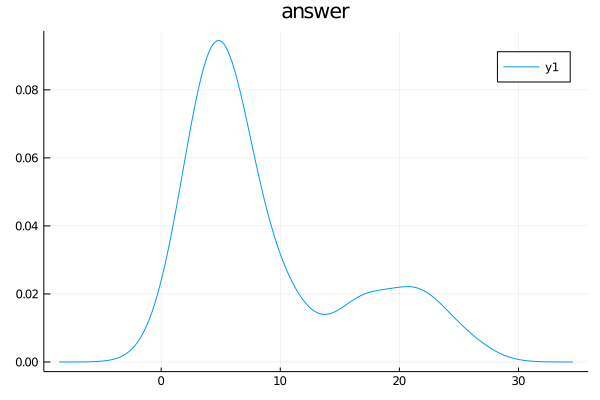

In [20]:
# データ点作成
# λ=5とλ=20のポアソン分布から7:3の確率で生成したデータ点
X = []
for i in 1:100
    K = rand(Categorical([0.7,0.3]))
    λ = ifelse(K==1,5,20)
    x = rand(Poisson(λ))
    push!(X,x)
end
p_ans = density(X, title="answer")
plot(p_ans)

In [21]:
model = variationalBayesPoisson(1,[],[1],[1],[1])
model = init(model, 2)

variationalBayesPoisson(2, Any[], [1.0, 1.0], [1.0, 1.0], [0.2585926034694314, 0.7414073965305685])

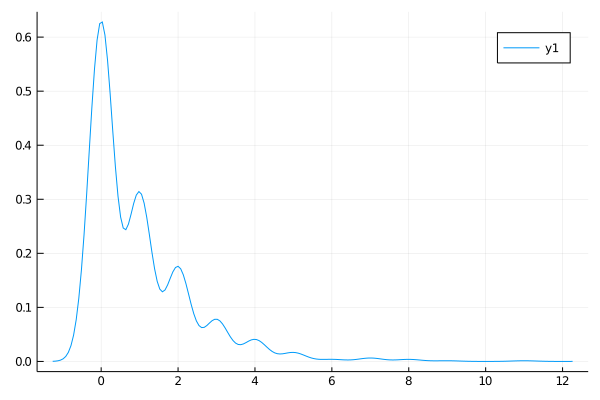

In [22]:
# 学習前にプロット
xs = [predict(model) for i in 1:1000]
density(xs)

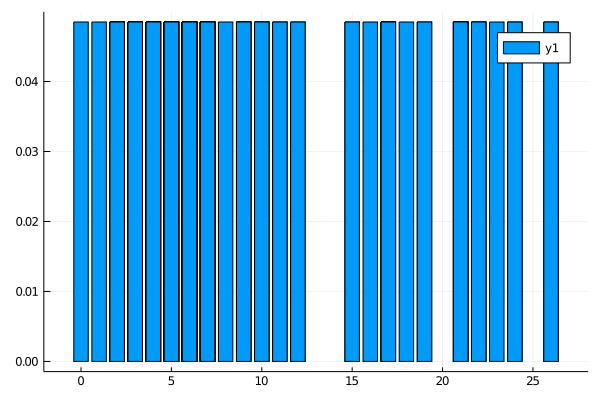

In [23]:
# 学習前にクラスタリング
bar(X,[cluster(model, X[n]) for n in 1:length(X)])

In [24]:
@time model = fit(model, X)

  1.414560 seconds (8.37 M allocations: 198.056 MiB, 7.92% gc time)


variationalBayesPoisson(2, Any[[0.9999885201496728, 1.1479850327202337e-5], [0.9998493669281563, 0.00015063307184371146], [0.9994545297488561, 0.0005454702511439849], [0.004685216875871678, 0.9953147831241284], [0.9999885201496728, 1.1479850327202337e-5], [2.082738302914923e-6, 0.9999979172616971], [0.9140823403565977, 0.08591765964340221], [0.9994545297488561, 0.0005454702511439849], [0.9747099182871993, 0.025290081712800738], [0.9998493669281563, 0.00015063307184371146]  …  [0.9994545297488561, 0.0005454702511439849], [0.9999885201496728, 1.1479850327202337e-5], [0.9999968310341244, 3.16896587556309e-6], [0.9998493669281563, 0.00015063307184371146], [0.004685216875871678, 0.9953147831241284], [0.9928886326538802, 0.007111367346119797], [0.7459893089600897, 0.25401069103991036], [0.9998493669281563, 0.00015063307184371146], [0.9999991252251544, 8.747748456785259e-7], [0.7459893089600897, 0.25401069103991036]], [700181.8135939713, 1.0818201864060282e6], [140204.69022420832, 59797.30977

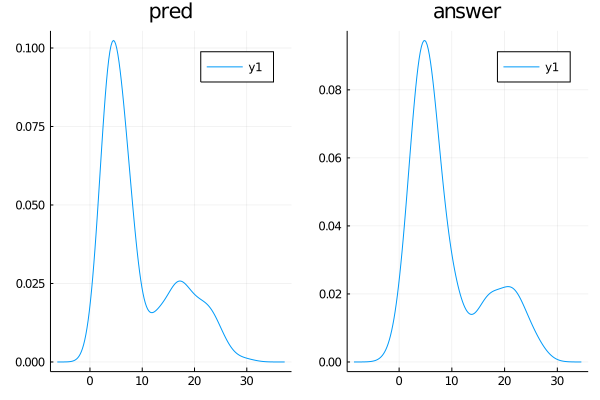

In [25]:
# 学習後の予測
xs = [predict(model) for i in 1:1000]
p_pred = density(xs, title="pred")
plot(p_pred,p_ans, layout=(1,2))

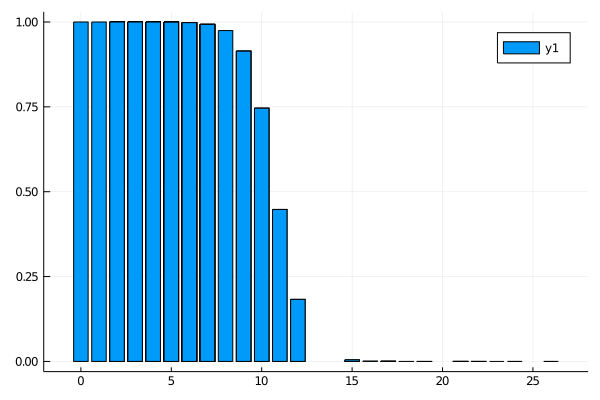

In [26]:
# 学習後のクラスタリング
bar(X, [cluster(model, X[n]) for n in 1:length(X)])

## 崩壊型ギブスサンプリング

崩壊型ギブスサンプリングは一旦飛ばします。

{{ '[須山敦志. 杉山将. ベイズ推論による機械学習入門. 講談社, 2017.](https://www.kspub.co.jp/book/detail/1538320.html)' | fndetail: 1 }}